In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.metrics import smape
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [2]:
def split_data_by_submarket(data, submkt_id, ntest):
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    submarkets = data['research_submkt_id'].unique()

    for submarket in submarkets:
        if submarket == submkt_id:
            submarket_data = data[data['research_submkt_id'] == submarket]
            train_submarket = submarket_data.iloc[:-ntest]
            test_submarket = submarket_data.iloc[-ntest:]
            train_data = pd.concat([train_data, train_submarket])
            test_data = pd.concat([test_data, test_submarket])

    return train_data, test_data


def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) between two arrays.

    Parameters:
        y_true (array-like): Array of true values.
        y_pred (array-like): Array of predicted values.

    Returns:
        float: SMAPE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    return np.mean(numerator / denominator) * 100


def get_submkt_forecast(df, num_lags, submkt_id):
    df_new = df[['date','research_submkt_id','real_hedonic_rent_submarket']]
    df_new['date'] = pd.to_datetime(df_new['date'])
    df['date'] = pd.to_datetime(df['date'])

    if num_lags is None:
        num_lags = 36  

    for lag in range(1, num_lags+1):
        df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
    df_new = df_new.dropna()
    df_new = df_new.sort_values(['date', 'research_submkt_id']).reset_index(drop=True)

    df_sel = df[["date", 
                 "research_submkt_id",
                 "real_market_level_rent",
                 "gdp_histfc",
                 "nominal_retail_sales_histfc",
                 "employment_histfc",
                 "real_ecommerce",
                 "spread_3m10y",
                 "real_retail_sales_ex_gas",
                 "imports_us",
                 "ecomm^2_pop",
                 "weighted_pop_estimate_cryr",
                 "weighted_hh_estimate_cryr"]]

    df_new = df_new.merge(df_sel,on=['date','research_submkt_id'],how='left')

    X = df_new.iloc[:, [0, 1] + list(range(3, len(df_new.columns)))]
    Y = df_new.iloc[:,:3]

    Y_train, Y_test = split_data_by_submarket(Y, submkt_id , 24)
    y_train = Y_train.iloc[:,-1]
    y_test = Y_test.iloc[:,-1]
    X_train, X_test = split_data_by_submarket(X, submkt_id, 24)
    x_train = X_train.iloc[:,2:]
    x_test = X_test.iloc[:,2:]


    #param_grid = {
    #    'n_estimators': [100, 150, 200, 250, 300],
    #    'max_depth': [3, 4, 5],
    #    'learning_rate': [0.15, 0.1, 0.01, 0.001]}
    
    param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.15, 0.1, 0.01, 0.001],
    #'subsample': [0.5, 0.75, 1],
    #'max_features': ['sqrt', 'log2', 0.5],
    #'gamma': [0, 0.1, 0.2, 0.3],
    #'colsample_bytree': [0.5, 0.75, 1],
    #'reg_alpha': [0, 0.1, 0.5, 1],
    #'reg_lambda': [0, 0.1, 0.5, 1]
}
    

    #model = XGBRegressor()
    #grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    #grid_search.fit(x_train, y_train)

    # Get the best parameters and best score
    #best_params = grid_search.best_params_
    #best_score = -grid_search.best_score_
    #print("Best Parameters:", best_params)
    #print("Best Score (RMSE):", best_score)

    #best_model = XGBRegressor(**best_params)
    #best_model.fit(x_train, y_train)
    
    model = XGBRegressor()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=make_scorer(smape))
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_
    print("Best Parameters:", best_params)
    print("Best Score (SMAPE):", best_score)

    best_model = XGBRegressor(**best_params)
    best_model.fit(x_train, y_train)

    
    #importance = best_model.feature_importances_
    #feature_importance_df = pd.DataFrame({'Attribute': x_train.columns, 'Importance': importance})

    #feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    #plt.figure(figsize=(10, 6))
    #plt.barh(feature_importance_df['Attribute'], feature_importance_df['Importance'])
    #plt.xlabel('Importance')
    #plt.ylabel('Attribute')
    #plt.title('Feature Importance')
    #plt.show()

        
    # using most important attributes to build new model
    #selected_attributes = feature_importance_df['Attribute'].head(15).tolist()
    #x_train_selected = x_train[selected_attributes]
    #x_test_selected = x_test[selected_attributes]
    #new_model = XGBRegressor(**best_params)
    #new_model.fit(x_train_selected, y_train)


    # predict
    #y_pred = new_model.predict(x_test_selected)
    y_pred = best_model.predict(x_test)
    smape_value = smape(y_test, y_pred)
    print(f"SMAPE: {smape_value:.2f}%")
    
    Y_test_pred = Y_test.copy()
    Y_test_pred['y_pred'] = y_pred
    
    return X, Y, Y_train, Y_test, y_train, y_test, X_train, X_test, x_train, x_test, Y_test_pred, smape_value  #, feature_importance_df

    
def plot_submkt_forecast(Y_test_pred, submkt_id):
    
    plt.plot(Y_test_pred['date'],Y_test_pred['real_hedonic_rent_submarket'],label='test')
    plt.plot(Y_test_pred['date'],Y_test_pred['y_pred'],label='pred')
    plt.title('{} submkt_rent forecasting'.format(submkt_id))
    plt.legend()

    return plt.show()


In [ ]:
def all_split_data_by_submarket(data, ntest):
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    submarkets = data['research_submkt_id'].unique()

    for submarket in submarkets:
        submarket_data = data[data['research_submkt_id'] == submarket]
        train_submarket = submarket_data.iloc[:-ntest]
        test_submarket = submarket_data.iloc[-ntest:]
        train_data = pd.concat([train_data, train_submarket])
        test_data = pd.concat([test_data, test_submarket])

    return train_data, test_data


def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) between two arrays.

    Parameters:
        y_true (array-like): Array of true values.
        y_pred (array-like): Array of predicted values.

    Returns:
        float: SMAPE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    return np.mean(numerator / denominator) * 100


def all_get_submkt_forecast(df, num_lags):
    df_new = df[['date','research_submkt_id','real_hedonic_rent_submarket']]
    df_new['date'] = pd.to_datetime(df_new['date'])
    df['date'] = pd.to_datetime(df['date'])

    if num_lags is None:
        num_lags = 36  

    for lag in range(1, num_lags+1):
        df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
    df_new = df_new.dropna()
    df_new = df_new.sort_values(['date', 'research_submkt_id']).reset_index(drop=True)
    
    df_sel = df[["date", 
                 "research_submkt_id",
                 "real_market_level_rent",
                 "gdp_histfc",
                 "nominal_retail_sales_histfc",
                 "employment_histfc",
                 "real_ecommerce",
                 "spread_3m10y",
                 "real_retail_sales_ex_gas",
                 "imports_us",
                 "ecomm^2_pop",
                 "weighted_pop_estimate_cryr",
                 "weighted_hh_estimate_cryr"]]

    df_new = df_new.merge(df_sel,on=['date','research_submkt_id'],how='left')

    X = df_new.iloc[:, [0, 1] + list(range(3, len(df_new.columns)))]
    Y = df_new.iloc[:,:3]

    Y_train, Y_test = all_split_data_by_submarket(Y,24)
    y_train = Y_train.iloc[:,-1]
    y_test = Y_test.iloc[:,-1]
    X_train, X_test = all_split_data_by_submarket(X,24)
    x_train = X_train.iloc[:,2:]
    x_test = X_test.iloc[:,2:]


    #param_grid = {
    #    'n_estimators': [100, 150, 200, 250, 300],
    #    'max_depth': [3, 4, 5],
    #    'learning_rate': [0.15, 0.1, 0.01, 0.001]}
    
    param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.15, 0.1, 0.01, 0.001],
    #'subsample': [0.5, 0.75, 1],
    #'max_features': ['sqrt', 'log2', 0.5],
    #'gamma': [0, 0.1, 0.2, 0.3],
    #'colsample_bytree': [0.5, 0.75, 1],
    #'reg_alpha': [0, 0.1, 0.5, 1],
    #'reg_lambda': [0, 0.1, 0.5, 1]
}

    #model = XGBRegressor()
    #grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    #grid_search.fit(x_train, y_train)

    # Get the best parameters and best score
    #best_params = grid_search.best_params_
    #best_score = -grid_search.best_score_
    #print("Best Parameters:", best_params)
    #print("Best Score (RMSE):", best_score)

    #best_model = XGBRegressor(**best_params)
    #best_model.fit(x_train, y_train)
    
        
    model = XGBRegressor()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=make_scorer(smape))
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_
    print("Best Parameters:", best_params)
    print("Best Score (SMAPE):", best_score)

    best_model = XGBRegressor(**best_params)
    best_model.fit(x_train, y_train)
    #importance = best_model.feature_importances_
    #feature_importance_df = pd.DataFrame({'Attribute': x_train.columns, 'Importance': importance})

    #feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    #plt.figure(figsize=(10, 6))
    #plt.barh(feature_importance_df['Attribute'], feature_importance_df['Importance'])
    #plt.xlabel('Importance')
    #plt.ylabel('Attribute')
    #plt.title('Feature Importance')
    #plt.show()
    
    # using most important attributes to build new model
    #selected_attributes = feature_importance_df['Attribute'].head(15).tolist()
    #x_train_selected = x_train[selected_attributes]
    #x_test_selected = x_test[selected_attributes]
    #new_model = XGBRegressor(**best_params)
    #new_model.fit(x_train_selected, y_train)


    # predict
    #y_pred = new_model.predict(x_test_selected)
    y_pred = best_model.predict(x_test)


    smape_value = smape(y_test, y_pred)
    print(f"SMAPE: {smape_value:.2f}%")
    
    Y_test_pred = Y_test.copy()
    Y_test_pred['y_pred'] = y_pred
    
    return Y_test_pred   #, feature_importance_df

    
def all_plot_submkt_forecast(Y_test_pred, submkt_id):

    x = Y_test_pred[Y_test_pred['research_submkt_id']== submkt_id]['date']
    y =  Y_test_pred[Y_test_pred['research_submkt_id']== submkt_id]['real_hedonic_rent_submarket']
    y_pred =  Y_test_pred[Y_test_pred['research_submkt_id']== submkt_id]['y_pred']

    plt.plot(x,y,label='test')
    plt.plot(x,y_pred,label='pred')
    plt.title('{} submkt_rent forecasting'.format(submkt_id))
    plt.legend()

    return plt.show()
    

In [ ]:
def get_compare_smape(Y_test_pred, all_Y_test_pred, submkt_id):
    y =  all_Y_test_pred[all_Y_test_pred['research_submkt_id']== submkt_id]['real_hedonic_rent_submarket']
    y1_pred =  all_Y_test_pred[all_Y_test_pred['research_submkt_id']== submkt_id]['y_pred']
    y2_pred = Y_test_pred['y_pred']
    
    smp1_whole_data = smape(y,y1_pred)
    smp2_single_data = smape(y,y2_pred)
    
    return smp1_whole_data, smp2_single_data

In [ ]:
def compare_plot(Y_test_pred, all_Y_test_pred, submkt_id):
    x = all_Y_test_pred[all_Y_test_pred['research_submkt_id']== submkt_id]['date']
    y =  all_Y_test_pred[all_Y_test_pred['research_submkt_id']== submkt_id]['real_hedonic_rent_submarket']
    y1_pred =  all_Y_test_pred[all_Y_test_pred['research_submkt_id']== submkt_id]['y_pred']
    y2_pred = Y_test_pred['y_pred']
    
    plt.plot(x,y,label='test')
    plt.plot(x,y1_pred,label='pred1(whole_submkt_data_build_model)')
    plt.plot(x,y2_pred,label='pred2(single_submkt_data_build_model)')
    plt.title('{} submkt_rent forecasting comparison'.format(submkt_id))
    plt.legend()
    
    smp1 = smape(y,y1_pred)
    smp2 = smape(y,y2_pred)
    
    return plt.show(), smp1, smp2

In [3]:
df = pd.read_csv('/mnt/container1/zqiao_Workspace/link-research/ad-hoc/zq-sandbox/submkt_data/submkt_train_data/pho_submkt_train_test_data.csv',index_col=0)

In [4]:
X, Y, Y_train, Y_test, y_train, y_test, X_train, X_test, x_train, x_test, Y_test_pred, smape_value = get_submkt_forecast(df,36,'PHO037')

/tmp/ipykernel_93129/1215182566.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['date'] = pd.to_datetime(df_new['date'])
/tmp/ipykernel_93129/1215182566.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
/tmp/ipykernel_93129/1215182566.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Best Parameters: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100}
Best Score (SMAPE): -144.19179746483036
SMAPE: 146.64%


In [9]:
X

,date,research_submkt_id,rent_1months_ago,rent_2months_ago,rent_3months_ago,rent_4months_ago,rent_5months_ago,rent_6months_ago,rent_7months_ago,rent_8months_ago,...,gdp_histfc,nominal_retail_sales_histfc,employment_histfc,real_ecommerce,spread_3m10y,real_retail_sales_ex_gas,imports_us,ecomm^2_pop,weighted_pop_estimate_cryr,weighted_hh_estimate_cryr
0,2001-02-01,PHO037,8.429784,8.472680,8.476210,8.440398,8.460014,8.490632,8.516866,8.480505,...,142293.127482,40907.465964,1567.191249,12938.204687,-0.223333,89254.311170,185.707296,0.814154,57298.031721,16953.789162
1,2001-02-01,PHO038,6.868247,6.875076,6.895329,6.898706,6.878764,6.887355,6.904910,6.810813,...,142293.127482,40907.465964,1567.191249,12938.204687,-0.223333,89254.311170,185.707296,0.814154,423462.954153,176776.235264
2,2001-02-01,PHO039,7.772118,7.772109,7.775501,7.769183,7.745279,7.759696,7.748712,7.702391,...,142293.127482,40907.465964,1567.191249,12938.204687,-0.223333,89254.311170,185.707296,0.814154,206665.753345,84755.250151
3,2001-02-01,PHO040,8.370461,8.273728,8.232606,8.243495,8.240890,8.118420,8.133908,8.096518,...,142293.127482,40907.465964,1567.191249,12938.204687,-0.223333,89254.311170,185.707296,0.814154,75439.315463,26879.287920
4,2001-02-01,PHO041,8.233423,8.248912,8.219992,8.181149,8.176995,8.201208,8.180075,8.097819,...,142293.127482,40907.465964,1567.191249,12938.204687,-0.223333,89254.311170,185.707296,0.814154,114035.858867,46457.095067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7519,2023-07-01,PHO061,7.328941,7.316052,7.306060,7.296276,7.273019,7.213068,7.175200,7.156619,...,269474.504159,148822.262498,2335.357286,260288.572900,-1.484426,130088.996556,368.766366,228.085533,136351.570536,37012.891665
7520,2023-07-01,PHO062,6.731348,6.711565,6.666796,6.632152,6.606574,6.592869,6.552799,6.518921,...,269474.504159,148822.262498,2335.357286,260288.572900,-1.484426,130088.996556,368.766366,228.085533,42473.769830,17325.596572
7521,2023-07-01,PHO063,6.841236,6.812503,6.793447,6.768671,6.746349,6.662717,6.626975,6.589367,...,269474.504159,148822.262498,2335.357286,260288.572900,-1.484426,130088.996556,368.766366,228.085533,209336.097949,96062.438534
7522,2023-07-01,PHO064,7.342340,7.334150,7.331181,7.331103,7.313662,7.240313,7.200667,7.167104,...,268365.511940,148215.434928,2326.302912,260288.572900,-1.484426,130088.996556,368.766366,227.218527,87889.878614,24809.537709


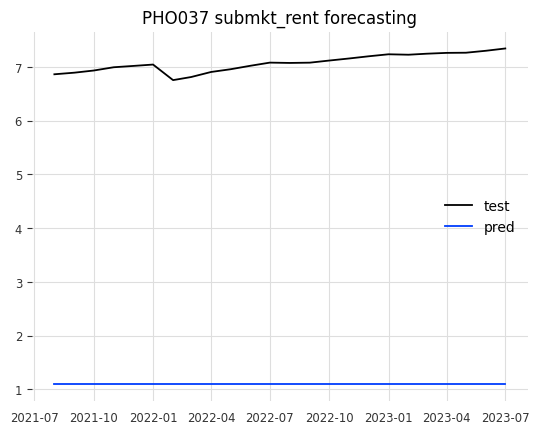

In [11]:
plot_submkt_forecast(Y_test_pred, 'PHO037')

In [ ]:
all_Y_test_pred = all_get_submkt_forecast(df,36)

In [ ]:
compare_plot(Y_test_pred, all_Y_test_pred, 'PHO038')

In [ ]:
get_compare_smape(Y_test_pred, all_Y_test_pred, 'PHO038')